### In this notebook, I will try to predict the telegrams' citation rate (regression) based purely on doc2vec bodies representations using classical ML algorithm (LightGBM)

### For the Neural Network approach see: https://colab.research.google.com/drive/1Q3C-O5lWVxh1nL8Vu8EOveEY87LjxTBW?usp=sharing

In [146]:
import lightgbm as lgb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, KFold, StratifiedKFold, ParameterGrid
from sklearn.metrics import make_scorer, mean_absolute_error, mean_squared_error

In [147]:
import warnings
warnings.filterwarnings("ignore")

In [148]:
RS = 42

In [149]:
def get_report(y_true, y_pred):
    print("Test MSE: ", mean_squared_error(y_true, y_pred))
    print("Test MAE: ", mean_absolute_error(y_true, y_pred))

In [150]:
df_labels = pd.read_csv("../data/labels.csv", index_col=0)[['n_cited']]
df_doc_vec = pd.read_csv("doc_vectors.csv", index_col=0)
df = df_labels.join(df_doc_vec)

In [151]:
df.n_cited.value_counts()

0      25624
1       7338
2       3784
3       2310
4       1647
       ...  
123        1
112        1
156        1
99         1
115        1
Name: n_cited, Length: 111, dtype: int64

In [152]:
df = df.iloc[1000:-100]

In [153]:
X, y = df.iloc[:, 1:].values, df.n_cited.values.reshape(-1, 1)

In [154]:
X.shape, y.shape

((47179, 256), (47179, 1))

#### default model performance check

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=RS)

In [13]:
gbm = lgb.LGBMRegressor(max_depth=4, n_estimators=150, learning_rate=0.1, reg_alpha=0.1, random_state=RS)
gbm.fit(X_train,y_train)

LGBMRegressor(max_depth=4, n_estimators=150, random_state=42, reg_alpha=0.1)

In [14]:
y_pred = gbm.predict(X_test)
y_train_pred = gbm.predict(X_train)
print("Train MSE: ", mean_squared_error(y_train, y_train_pred))
print("Train MAE: ", mean_absolute_error(y_train, y_train_pred))
get_report(y_test, y_pred)

Train MSE:  32.12907534482048
Train MAE:  2.628462844502369
Test MSE:  44.29754219565553
Test MAE:  2.9461339621676332


In [24]:
# we are wrong in 3 citations in average

### tuning time

In [64]:
NFOLDS = 3
kf = KFold(n_splits=NFOLDS, shuffle=True, random_state=RS)

In [65]:
scorer = make_scorer(mean_squared_error, greater_is_better=False)

In [66]:
model = lgb.LGBMRegressor()

In [67]:
parameters = {
    'n_estimators': [100, 250, 500, 1000],
    'max_depth': [2, 4, 6],
    'reg_alpha': [0.1, 1],
    'learning_rate': [0.001, 0.01, 0.1]
}

In [68]:
RSCV = RandomizedSearchCV(model, parameters, scoring=scorer, cv=kf, n_iter=333, verbose=3)

In [69]:
RSCV

RandomizedSearchCV(cv=KFold(n_splits=3, random_state=42, shuffle=True),
                   estimator=LGBMRegressor(), n_iter=333,
                   param_distributions={'learning_rate': [0.001, 0.01, 0.1],
                                        'max_depth': [2, 4, 6],
                                        'n_estimators': [100, 250, 500, 1000],
                                        'reg_alpha': [0.1, 1]},
                   scoring=make_scorer(mean_squared_error, greater_is_better=False),
                   verbose=3)

In [70]:
RSCV.fit(X_train, y_train)

Fitting 3 folds for each of 72 candidates, totalling 216 fits
[CV 1/3] END learning_rate=0.001, max_depth=2, n_estimators=100, reg_alpha=0.1;, score=-56.966 total time=   0.7s
[CV 2/3] END learning_rate=0.001, max_depth=2, n_estimators=100, reg_alpha=0.1;, score=-61.184 total time=   0.7s
[CV 3/3] END learning_rate=0.001, max_depth=2, n_estimators=100, reg_alpha=0.1;, score=-58.447 total time=   0.7s
[CV 1/3] END learning_rate=0.001, max_depth=2, n_estimators=100, reg_alpha=1;, score=-56.966 total time=   0.7s
[CV 2/3] END learning_rate=0.001, max_depth=2, n_estimators=100, reg_alpha=1;, score=-61.185 total time=   0.7s
[CV 3/3] END learning_rate=0.001, max_depth=2, n_estimators=100, reg_alpha=1;, score=-58.447 total time=   0.8s
[CV 1/3] END learning_rate=0.001, max_depth=2, n_estimators=250, reg_alpha=0.1;, score=-55.613 total time=   1.1s
[CV 2/3] END learning_rate=0.001, max_depth=2, n_estimators=250, reg_alpha=0.1;, score=-59.780 total time=   1.0s
[CV 3/3] END learning_rate=0.001

RandomizedSearchCV(cv=KFold(n_splits=3, random_state=42, shuffle=True),
                   estimator=LGBMRegressor(), n_iter=333,
                   param_distributions={'learning_rate': [0.001, 0.01, 0.1],
                                        'max_depth': [2, 4, 6],
                                        'n_estimators': [100, 250, 500, 1000],
                                        'reg_alpha': [0.1, 1]},
                   scoring=make_scorer(mean_squared_error, greater_is_better=False),
                   verbose=3)

In [76]:
best_estimator = RSCV.best_estimator_

In [77]:
y_pred = best_estimator.predict(X_test)  
y_train_pred = best_estimator.predict(X_train)
print("Train MSE: ", mean_squared_error(y_train, y_train_pred))
print("Train MAE: ", mean_absolute_error(y_train, y_train_pred))
get_report(y_test, y_pred)

Train MSE:  8.253869917380685
Train MAE:  1.5652725324025343
Test MSE:  41.707873629624395
Test MAE:  2.8730484099375566


In [78]:
RSCV.best_params_

{'reg_alpha': 0.1, 'n_estimators': 500, 'max_depth': 6, 'learning_rate': 0.1}

In [83]:
# looks overfited, add more regularization
gbm = lgb.LGBMRegressor(**{'reg_alpha': 0.6, 'n_estimators': 500, 'max_depth': 6, 'learning_rate': 0.1, 'reg_lambda': 0.3})

In [84]:
gbm.fit(X_train,y_train)

y_pred = gbm.predict(X_test)
y_train_pred = gbm.predict(X_train)

print("Train MSE: ", mean_squared_error(y_train, y_train_pred))
print("Train MAE: ", mean_absolute_error(y_train, y_train_pred))
get_report(y_test, y_pred)

Train MSE:  8.406973638083233
Train MAE:  1.5734056818811444
Test MSE:  41.13650735523771
Test MAE:  2.875264318881084


check the train test values dist, maybe there is an imbalance

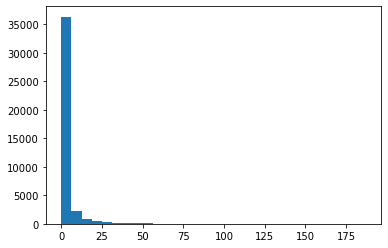

2.895633912873608
7.7495249042153205


In [93]:
plt.hist(y_train, bins=30)
plt.show()
print(np.mean(y_train))
print(np.std(y_train))

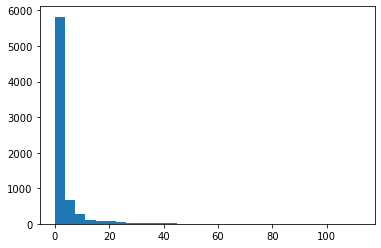

2.9755085097550853
7.888077126849685


In [94]:
plt.hist(y_test, bins=30)
plt.show()
print(np.mean(y_test))
print(np.std(y_test))

### Let's convert the predictions to the class labels and see the classification metrics

In [107]:
cls_df = pd.DataFrame(y_test, columns=['true_val'])
cls_df['pred_val'] = y_pred.astype(np.int64)

In [108]:
# the threshold we used during the class conversion:
# x < 3 --> cls 0
# 3 <= x < 14 --> cls 1
# 14 <= x --> cls 2

In [109]:
cls_df['true_class'] = cls_df['true_val'].apply(lambda x: 0 if x<3 else 1 if 3<=x<14 else 2)
cls_df['pred_class'] = cls_df['pred_val'].apply(lambda x: 0 if x<3 else 1 if 3<=x<14 else 2)

In [110]:
from sklearn.metrics import balanced_accuracy_score, classification_report, confusion_matrix 

print("Test accuracy: ", balanced_accuracy_score(cls_df['true_class'].values, cls_df['pred_class'].values))
print("Report: ")
print(classification_report(cls_df['true_class'].values, cls_df['pred_class'].values))
print("Confusion matrix:")
print(confusion_matrix(cls_df['true_class'].values, cls_df['pred_class'].values))

Test accuracy:  0.5499630369753913
Report: 
              precision    recall  f1-score   support

           0       0.87      0.84      0.86      5451
           1       0.39      0.48      0.43      1396
           2       0.49      0.33      0.39       380

    accuracy                           0.75      7227
   macro avg       0.58      0.55      0.56      7227
weighted avg       0.76      0.75      0.75      7227

Confusion matrix:
[[4596  811   44]
 [ 642  667   87]
 [  39  216  125]]


In [112]:
cls_df  # we're messing the class 1 and 2 cause of the extreeme outliers in the class 2

,true_val,pred_val,true_class,pred_class
0,0,0,0,0
1,1,1,0,0
2,94,6,2,1
3,0,1,0,0
4,11,3,1,1
...,...,...,...,...
7222,0,2,0,0
7223,0,0,0,0
7224,0,0,0,0
7225,0,-1,0,0


### what if we consider binary prediction (class 1 and 2 merged)

In [113]:
cls_df['true_class'] = cls_df['true_val'].apply(lambda x: 0 if x<3 else 1)
cls_df['pred_class'] = cls_df['pred_val'].apply(lambda x: 0 if x<3 else 1)

In [114]:
print("Test accuracy: ", balanced_accuracy_score(cls_df['true_class'].values, cls_df['pred_class'].values))
print("Report: ")
print(classification_report(cls_df['true_class'].values, cls_df['pred_class'].values))
print("Confusion matrix:")
print(confusion_matrix(cls_df['true_class'].values, cls_df['pred_class'].values))

Test accuracy:  0.7298510501420519
Report: 
              precision    recall  f1-score   support

           0       0.87      0.84      0.86      5451
           1       0.56      0.62      0.59      1776

    accuracy                           0.79      7227
   macro avg       0.72      0.73      0.72      7227
weighted avg       0.79      0.79      0.79      7227

Confusion matrix:
[[4596  855]
 [ 681 1095]]


### Replace the citation values above 20 to just 20, so the extremely hight values won't misslead the model

In [155]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=RS)
y_train[y_train > 20] = 20

In [156]:
gbm = lgb.LGBMRegressor(**{'reg_alpha': 0.6, 'n_estimators': 500, 'max_depth': 6, 'learning_rate': 0.1, 'reg_lambda': 0.3})

In [157]:
gbm.fit(X_train,y_train)

y_pred = gbm.predict(X_test)
y_train_pred = gbm.predict(X_train)

print("Train MSE: ", mean_squared_error(y_train, y_train_pred))
print("Train MAE: ", mean_absolute_error(y_train, y_train_pred))
get_report(y_test, y_pred)

Train MSE:  3.9972715922638953
Train MAE:  1.2522048051623194
Test MSE:  40.05031633373903
Test MAE:  2.5866894306324606


In [158]:
gbm.fit(X_train,y_train)

y_pred = gbm.predict(X_test).astype(int)
y_train_pred = gbm.predict(X_train).astype(int)

print("Train MSE: ", mean_squared_error(y_train, y_train_pred))
print("Train MAE: ", mean_absolute_error(y_train, y_train_pred))
get_report(y_test, y_pred)

Train MSE:  4.21627350256845
Train MAE:  1.1011171512642761
Test MSE:  40.66892751165748
Test MAE:  2.401582591493571


In [159]:
# see class metrics:
cls_df = pd.DataFrame(y_test, columns=['true_val'])
cls_df['pred_val'] = y_pred.astype(np.int64)

cls_df['true_class'] = cls_df['true_val'].apply(lambda x: 0 if x<3 else 1 if 3<=x<14 else 2)
cls_df['pred_class'] = cls_df['pred_val'].apply(lambda x: 0 if x<3 else 1 if 3<=x<14 else 2)

print("Test accuracy: ", balanced_accuracy_score(cls_df['true_class'].values, cls_df['pred_class'].values))
print("Report: ")
print(classification_report(cls_df['true_class'].values, cls_df['pred_class'].values))
print("Confusion matrix:")
print(confusion_matrix(cls_df['true_class'].values, cls_df['pred_class'].values))

Test accuracy:  0.49548488856716877
Report: 
              precision    recall  f1-score   support

           0       0.89      0.87      0.88      5514
           1       0.39      0.54      0.45      1194
           2       0.60      0.08      0.13       369

    accuracy                           0.77      7077
   macro avg       0.63      0.50      0.49      7077
weighted avg       0.79      0.77      0.77      7077

Confusion matrix:
[[4790  718    6]
 [ 534  647   13]
 [  34  307   28]]


In [160]:
# see binary metrics:

cls_df['true_class'] = cls_df['true_val'].apply(lambda x: 0 if x<3 else 1)
cls_df['pred_class'] = cls_df['pred_val'].apply(lambda x: 0 if x<3 else 1)

print("Test accuracy: ", balanced_accuracy_score(cls_df['true_class'].values, cls_df['pred_class'].values))
print("Report: ")
print(classification_report(cls_df['true_class'].values, cls_df['pred_class'].values))
print("Confusion matrix:")
print(confusion_matrix(cls_df['true_class'].values, cls_df['pred_class'].values))

Test accuracy:  0.7526470745901028
Report: 
              precision    recall  f1-score   support

           0       0.89      0.87      0.88      5514
           1       0.58      0.64      0.61      1563

    accuracy                           0.82      7077
   macro avg       0.74      0.75      0.74      7077
weighted avg       0.82      0.82      0.82      7077

Confusion matrix:
[[4790  724]
 [ 568  995]]


- Train MSE:  4.21627350256845
- Train MAE:  1.1011171512642761
- Test MSE:  40.66892751165748
- Test MAE:  2.401582591493571